# PARCtorch

## Normalization

In [9]:
import sys
import os

# Add the root directory (PARCTorch) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))
from data.normalization import compute_min_max

In [10]:
# Example usage
data_dirs = [
    "/project/vil_baek/data/physics/PARCTorch/HMX/train",
    "/project/vil_baek/data/physics/PARCTorch/HMX/test",
]
output_file = "../data/hmx_min_max.json"
compute_min_max(data_dirs, output_file)

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/jtb3sud/PARCtorch/PARCtorch/demos
Total files to process: 134
Processed 100/134 files.
Processed 134/134 files.
Channel-wise min values: [300.0, -1186907500.0, 0.0, -1995.0012, -5521.5503]
Channel-wise max values: [5000.0, 69721220000.0, 1.0, 7184.0073, 5215.695]
Min and max values saved to '/sfs/gpfs/tardis/home/jtb3sud/PARCtorch/PARCtorch/data/hmx_min_max.json'.


## Create Data Loader for Training

In [11]:
# Now import the utilities
from data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from utilities.viz import visualize_channels, save_gifs_with_ground_truth
import torch
from torch.utils.data import DataLoader
import logging

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

# Example configuration for HMX dataset
data_dir_train = "/project/vil_baek/data/physics/PARCTorch/HMX/train"  # Replace with your actual train directory path
data_dir_test = "/project/vil_baek/data/physics/PARCTorch/HMX/test"  # Replace with your actual test directory path
future_steps = 1
# Path to the min_max.json file
min_max_path = os.path.join("..", "data", "hmx_min_max.json")  # Correct path
batch_size = 1

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_train],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

Listing samples: 100%|██████████| 100/100 [00:00<00:00, 547.04it/s]


## Visualize the Data was Laoded Properly

Channel Data Statistics:
Channel 0: IC min=0.0, IC max=0.0089606624096632
  Step 1: min=0.0, max=0.1176629364490509
Channel 1: IC min=0.016738668084144592, IC max=0.022297993302345276
  Step 1: min=0.016364343464374542, max=0.16503430902957916
Channel 2: IC min=0.0, IC max=1.0
  Step 1: min=0.0, max=1.0
Channel 3: IC min=0.21734386682510376, IC max=0.24943038821220398
  Step 1: min=0.21734386682510376, max=0.52634197473526
Channel 4: IC min=0.5142427086830139, IC max=0.5142427086830139
  Step 1: min=0.4188327491283417, max=0.59377521276474


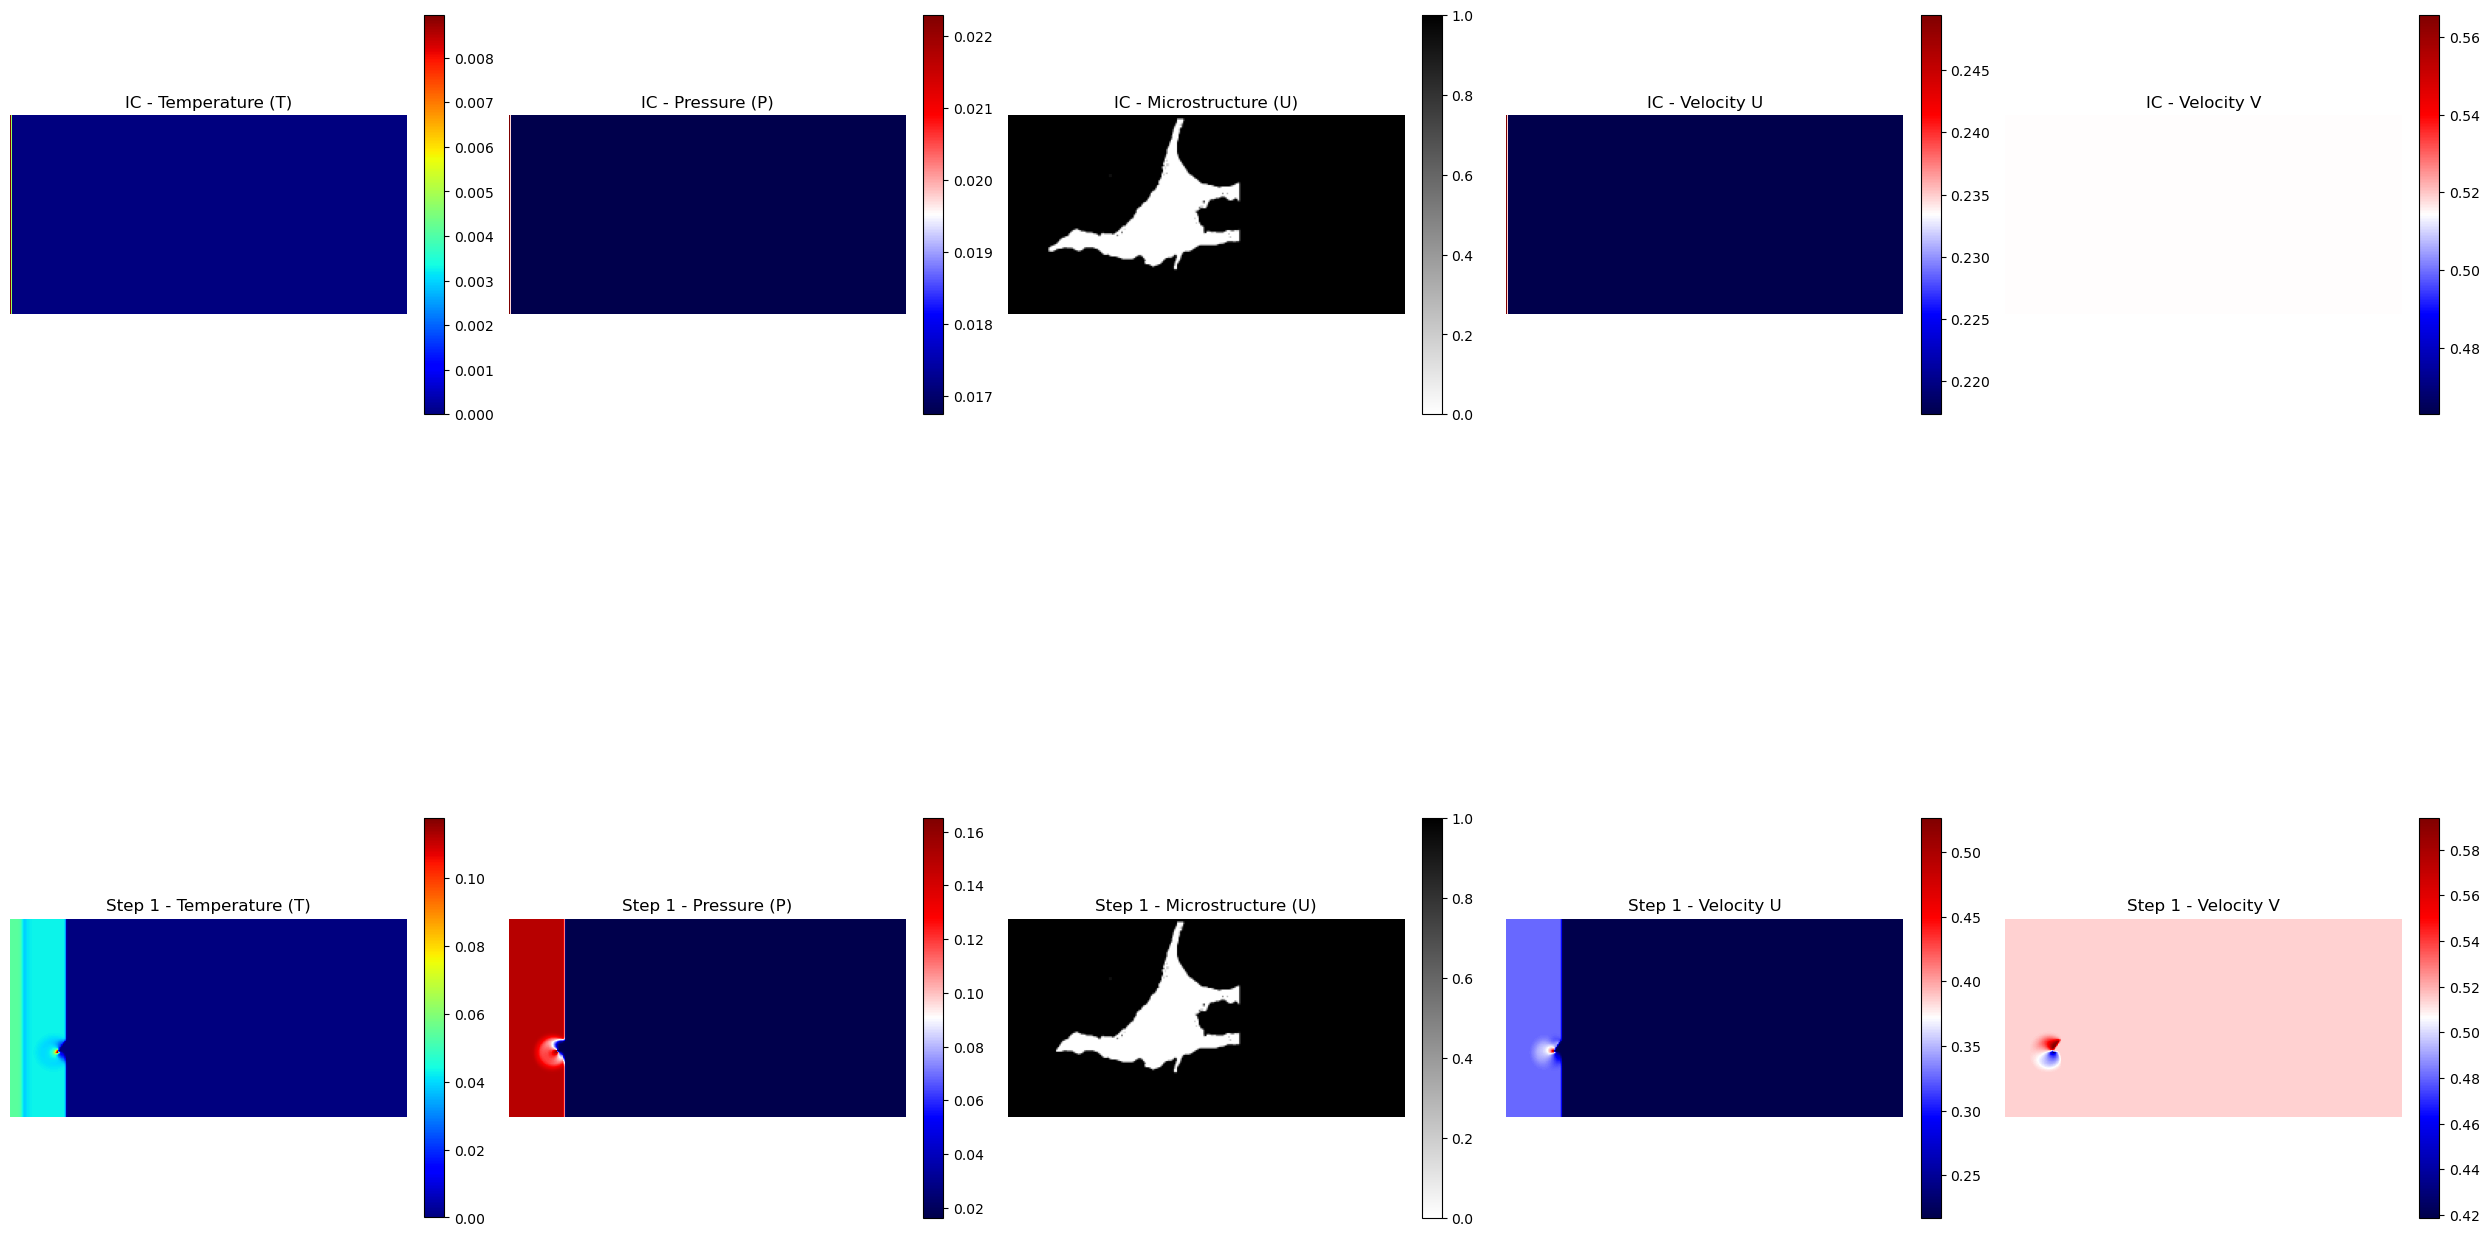

In [12]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = [
        "Temperature (T)",
        "Pressure (P)",
        "Microstructure (U)",
        "Velocity U",
        "Velocity V",
    ]
    custom_cmaps = ["jet", "seismic", "binary", "seismic", "seismic"]

    visualize_channels(
        ic,
        t0,
        t1,
        target,
        channel_names=channel_names,
        channel_cmaps=custom_cmaps,
    )
    break  # Visualize one batch for now

## Build your PARC Model

In [13]:
import sys

sys.path.append("../../")

In [14]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import Differentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.rk4 import RK4
from utilities.unet_deform import UNet

In [15]:
from torch.optim import Adam

In [16]:
n_fe_features = 128

# Instantiate the UNet model with deformable convolutions
unet_em = UNet(
    block_dimensions=[64, 64 * 2, 64 * 4, 64 * 8, 64 * 16],
    input_channels=5,  # Assuming your input has 5 channels
    output_channels=n_fe_features,
    up_block_use_concat=[False, True, False, True],  # Use specified concat flags
    skip_connection_indices=[2, 0],  # Specify which skip connections to use
    use_deform=True  # Enable deformable convolutions
)


right_diff = FiniteDifference(padding_mode="replicate").cuda()
rk4_int = RK4().cuda()

diff_em = Differentiator(
    3,  # 3 state variables: T, p, mu. We always assume 2 velocity channels being the last 2 channels
    n_fe_features,  # Number of features returned by the feature extraction network: 128
    [0, 1, 2, 3, 4],  # Channel indices to calculate advection: all channels
    [0],  # Channel indices to calculate diffusion: T
    unet_em,  # Feature extraction network: unet_em
    "constant",  # Padding mode: constant padding of zero
    right_diff,  # Finite difference method: replicate image gradients
).cuda()

ddi_list = [None] * 5

em_int = Integrator(
    True,  # Clip input data between 0 and 1
    [],  # No Poisson
    rk4_int,  # RK4 integration
    ddi_list,  # Data-driven integrators: 1 for each state variable and 1 for velocities
    "constant",  # Padding mode: constant padding of zero
    right_diff,  # Finite difference method: replicate image gradients
).cuda()

criterion = torch.nn.L1Loss().cuda()
model = PARCv2(diff_em, em_int, criterion).cuda()
optimizer = Adam(model.parameters(), lr=1e-5)

## Train the Model 

In [ ]:
from train import train_model

# Example usage:
train_model(
    model,
    train_loader,
    criterion,
    optimizer,
    num_epochs=100,
    save_dir="../../../weights/em_deform",
)

Epoch 1/100: 100%|██████████| 1400/1400 [05:55<00:00,  3.93it/s, Batch Loss=0.000475]

Epoch [1/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 2/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000455]

Epoch [2/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 3/100: 100%|██████████| 1400/1400 [05:48<00:00,  4.02it/s, Batch Loss=0.00046] 

Epoch [3/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 4/100: 100%|██████████| 1400/1400 [05:48<00:00,  4.02it/s, Batch Loss=0.000563]

Epoch [4/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 5/100: 100%|██████████| 1400/1400 [05:46<00:00,  4.04it/s, Batch Loss=0.000446]

Epoch [5/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 6/100: 100%|██████████| 1400/1400 [05:46<00:00,  4.04it/s, Batch Loss=0.000471]

Epoch [6/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 7/100: 100%|██████████| 1400/1400 [05:46<00:00,  4.04it/s, Batch Loss=0.000527]

Epoch [7/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 8/100: 100%|██████████| 1400/1400 [05:46<00:00,  4.04it/s, Batch Loss=0.000463]

Epoch [8/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 9/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000475]

Epoch [9/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 10/100: 100%|██████████| 1400/1400 [05:46<00:00,  4.03it/s, Batch Loss=0.000516]

Epoch [10/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 11/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000449]

Epoch [11/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 12/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000454]

Epoch [12/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 13/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000577]

Epoch [13/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 14/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000616]

Epoch [14/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 15/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000495]

Epoch [15/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 16/100: 100%|██████████| 1400/1400 [05:49<00:00,  4.00it/s, Batch Loss=0.00045] 

Epoch [16/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 17/100: 100%|██████████| 1400/1400 [05:50<00:00,  4.00it/s, Batch Loss=0.000476]

Epoch [17/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 18/100: 100%|██████████| 1400/1400 [05:48<00:00,  4.01it/s, Batch Loss=0.000493]

Epoch [18/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 19/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000433]

Epoch [19/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 20/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.03it/s, Batch Loss=0.000453]

Epoch [20/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 21/100: 100%|██████████| 1400/1400 [05:47<00:00,  4.02it/s, Batch Loss=0.000452]

Epoch [21/100], Average Loss: 0.0008
Model weights saved at ../../../weights/em_deform/model.pth



Epoch 22/100:  36%|███▌      | 507/1400 [02:06<03:42,  4.02it/s, Batch Loss=0.000552]

## Load the Model

In [17]:
from utilities.load import load_model_weights


# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = (
    "/home/jtb3sud/weights/em_deform/model.pth"  # Replace with your path
)
model = load_model_weights(model, model_weights_path, device)

Loaded model weights from '/home/jtb3sud/weights/em_deform/model.pth'


## Create the Sequence DataLoader
### This will contain the t=0 for each test file

In [ ]:
# Initialize the dataset
future_steps = 3
seq_dataset = InitialConditionDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=initial_condition_collate_fn,
)

## Ground Truth Loader

In [ ]:
# Initialize the dataset
gt_dataset = GenericPhysicsDataset(
    data_dirs=[data_dir_test],
    future_steps=future_steps,
    min_max_path=min_max_path,
)

# Create DataLoader for training dataset
gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

## Visualize the Results

In [ ]:
# Set the model to evaluation mode
model.eval()

# Define channel names and colormaps
channels = ["pressure", "Reynolds", "u", "v"]  # Adjust as per your data
cmaps = [
    "viridis",
    "plasma",
    "inferno",
    "magma",
]  # Adjust as per your preference

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=0.2,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset